11493376/11490434 [==============================] - 0s 0us/step


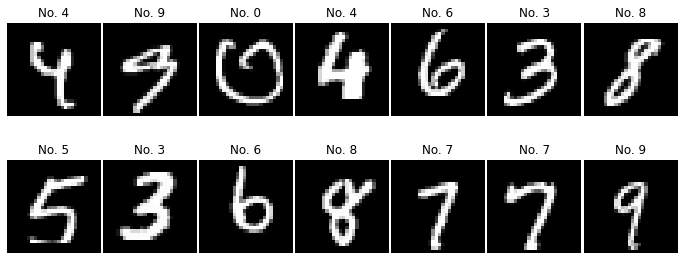

In [ ]:
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data

# load the data - it returns 2 tuples of digits & labels - one for
# the train set & the other for the test set
(train_digits, train_labels), (test_digits, test_labels) = load_data()

# display 14 random images from the training set
import numpy as np
np.random.seed(123)

rand_14 = np.random.randint(0, train_digits.shape[0],14)
sample_digits = train_digits[rand_14]
sample_labels = train_labels[rand_14]
# code to view the images
num_rows, num_cols = 2, 7
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * 7 + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_digits[image_index], cmap='gray')
        ax[r,c].set_title('No. %d' % sample_labels[image_index])
plt.show()
plt.close()

In [ ]:
# some variables...
image_height = train_digits.shape[1]  
image_width = train_digits.shape[2]
num_channels = 1  # we have grayscale images
# NOTE: image_height == image_width == 28

# re-shape the images data
train_data = np.reshape(train_digits, (train_digits.shape[0], image_height, image_width, num_channels))
test_data = np.reshape(test_digits, (test_digits.shape[0],image_height, image_width, num_channels))

# re-scale the image data to values between (0.0,1.0]
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

# one-hot encode the labels - we have 10 output classes
# so 3 -> [0 0 0 1 0 0 0 0 0 0], 5 -> [0 0 0 0 0 1 0 0 0 0] & so on
from keras.utils import to_categorical
num_classes = 10
train_labels_cat = to_categorical(train_labels,num_classes)
test_labels_cat = to_categorical(test_labels,num_classes)
train_labels_cat.shape, test_labels_cat.shape

((60000, 10), (10000, 10))

In [ ]:
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now set-aside 10% of the train_data/labels as the
# cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set from train_data/labels
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]

# leave rest in training set
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

# NOTE: We will train on train_data2/train_labels_cat2 and 
# cross-validate on val_data/val_labels_cat

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
def build_model():
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(image_height, image_width, num_channels)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))    
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(128, activation='relu'))
    # output layer
    model.add(Dense(num_classes, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
    return model
model=build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [ ]:
history = model.fit(train_data2, train_labels_cat2, 
                    epochs=15, batch_size=64,
                    validation_data=(val_data, val_labels_cat))

Epoch 1/15
844/844 [==============================] - 4s 5ms/step - loss: 0.1809 - acc: 0.9454 - f1_m: 0.9357 - precision_m: 0.9534 - recall_m: 0.9260 - val_loss: 0.0593 - val_acc: 0.9805 - val_f1_m: 0.9807 - val_precision_m: 0.9831 - val_recall_m: 0.9784
Epoch 2/15
844/844 [==============================] - 4s 5ms/step - loss: 0.0493 - acc: 0.9843 - f1_m: 0.9845 - precision_m: 0.9864 - recall_m: 0.9827 - val_loss: 0.0531 - val_acc: 0.9837 - val_f1_m: 0.9839 - val_precision_m: 0.9858 - val_recall_m: 0.9820
Epoch 3/15
844/844 [==============================] - 4s 5ms/step - loss: 0.0336 - acc: 0.9896 - f1_m: 0.9897 - precision_m: 0.9908 - recall_m: 0.9887 - val_loss: 0.0392 - val_acc: 0.9868 - val_f1_m: 0.9871 - val_precision_m: 0.9877 - val_recall_m: 0.9865
Epoch 4/15
844/844 [==============================] - 4s 5ms/step - loss: 0.0271 - acc: 0.9912 - f1_m: 0.9913 - precision_m: 0.9921 - recall_m: 0.9905 - val_loss: 0.0282 - val_acc: 0.9897 - val_f1_m: 0.9899 - val_precision_m: 0.9908

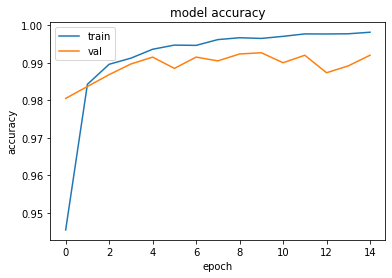

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('p1.png')
plt.show()


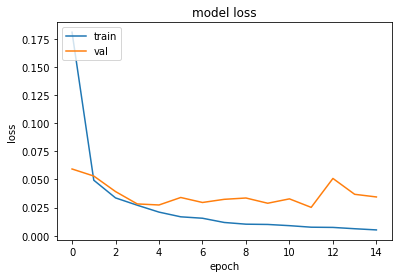

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('p2.png')
plt.show()


In [ ]:
from google.colab import files
files.download("p2.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_data, test_labels_cat, batch_size=64)
print('Test loss: %.4f accuracy: %.4f' % (loss, accuracy))

157/157 [==============================] - 1s 3ms/step - loss: 0.0310 - acc: 0.9920 - f1_m: 0.9921 - precision_m: 0.9923 - recall_m: 0.9918
Test loss: 0.0310 accuracy: 0.9920
